In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import seaborn as sns
matplotlib.rcParams['image.cmap'] = 'bone'

In [3]:
path = Path('D:/Datasets/TN_SC')
os.listdir(path)

['image', 'mask', 'TNSCUI2020_train.rar', 'train.csv']

In [4]:
images = path/'image'
masks = path/'mask'
image_items = get_image_files(images)
mask_items = get_image_files(masks)
image_items, mask_items

((#3644) [Path('D:/Datasets/TN_SC/image/100.PNG'),Path('D:/Datasets/TN_SC/image/1002.PNG'),Path('D:/Datasets/TN_SC/image/1004.PNG'),Path('D:/Datasets/TN_SC/image/1010.PNG'),Path('D:/Datasets/TN_SC/image/1012.PNG'),Path('D:/Datasets/TN_SC/image/102.PNG'),Path('D:/Datasets/TN_SC/image/1020.PNG'),Path('D:/Datasets/TN_SC/image/1024.PNG'),Path('D:/Datasets/TN_SC/image/1026.PNG'),Path('D:/Datasets/TN_SC/image/1029.PNG')...],
 (#3644) [Path('D:/Datasets/TN_SC/mask/100.PNG'),Path('D:/Datasets/TN_SC/mask/1002.PNG'),Path('D:/Datasets/TN_SC/mask/1004.PNG'),Path('D:/Datasets/TN_SC/mask/1010.PNG'),Path('D:/Datasets/TN_SC/mask/1012.PNG'),Path('D:/Datasets/TN_SC/mask/102.PNG'),Path('D:/Datasets/TN_SC/mask/1020.PNG'),Path('D:/Datasets/TN_SC/mask/1024.PNG'),Path('D:/Datasets/TN_SC/mask/1026.PNG'),Path('D:/Datasets/TN_SC/mask/1029.PNG')...])

In [4]:
tst_img = image_items[17]
tst_msk = mask_items[7]

In [7]:
get_msk = lambda o: path/'mask'/f'{o.stem}{o.suffix}'
get_msk

<function __main__.<lambda>(o)>

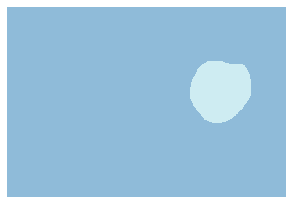

In [6]:
msk = PILMask.create(get_msk(tst_img))
msk.show(figsize=(5,5), alpha=0.5)

In [96]:
batch_tfms = [IntToFloatTensor(div_mask=128), Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]

tnsc = DataBlock(blocks=(ImageBlock, MaskBlock),
                   get_items=get_image_files,
                   #splitter=RandomSplitter(),
                   get_y=get_msk,
                  # get_y=parent_label
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [97]:
tnsc.summary(path)

Setting-up type transforms pipelines
Found 7288 items
2 datasets of sizes 5831,1457
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      D:\Datasets\TN_SC\image\8426.PNG
    applying PILBase.create gives
      PILImage mode=RGB size=508x480
  Pipeline: <lambda> -> PILBase.create
    starting from
      D:\Datasets\TN_SC\image\8426.PNG
    applying <lambda> gives
      D:\Datasets\TN_SC\mask\8426.PNG
    applying PILBase.create gives
      PILMask mode=L size=508x480

Final sample: (PILImage mode=RGB size=508x480, PILMask mode=L size=508x480)


Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> Normalize

Building one batch
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> RandomResizedCrop -> ToTensor
    starting from
      (PILImage mode=RGB size=50

In [9]:
import gc
gc.collect()

29685

In [9]:
dls = tnsc.dataloaders(path/'image', bs=4, num_workers=0)

In [10]:
dls = dls.cuda()

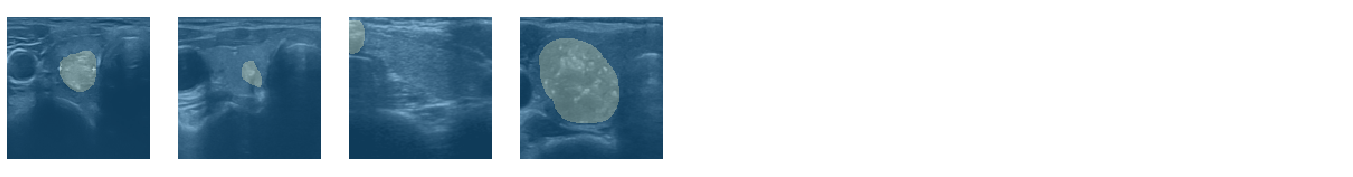

In [11]:
dls.show_batch(max_n=8, nrows=1, ncols=8,)

In [12]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger
dice = Dice()

In [13]:
#learn = unet_learner(dls, xresnet50,n_out=2)
learn = unet_learner(dls, resnet18, metrics=dice, config=config, opt_func=opt, n_out=2)

In [15]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice,time
0,0.232342,0.165065,0.719603,04:47


epoch,train_loss,valid_loss,dice,time
0,0.160028,0.141907,0.777181,05:17
1,0.147635,0.107172,0.825356,05:22
2,0.295992,0.099591,0.845563,05:19
3,0.091640,0.086613,0.858504,05:22
4,0.093833,0.084566,0.862754,05:24


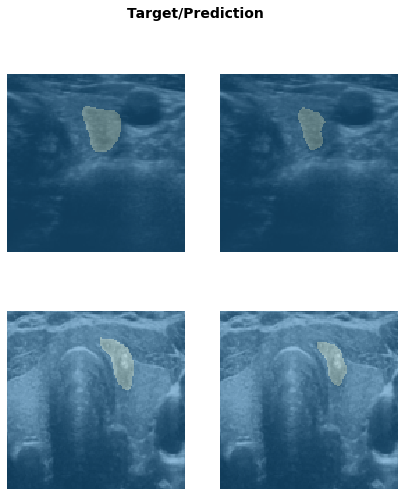

In [16]:
learn.show_results(max_n=8, figsize=(7,8))

In [17]:
learn.save('TNSC_two')

In [14]:
learn.load('TNSC_two')

In [15]:
learn.model.eval();

In [16]:
preds, ys = learn.get_preds()

In [17]:
len(preds)

728

In [18]:
preds2 = preds[:,1,...]
ys = ys.squeeze()
len(ys)

728

In [19]:
dls.valid_ds

(#728) [(PILImage mode=RGB size=624x549, PILMask mode=L size=624x549),(PILImage mode=RGB size=614x443, PILMask mode=L size=614x443),(PILImage mode=RGB size=896x606, PILMask mode=L size=896x606),(PILImage mode=RGB size=606x479, PILMask mode=L size=606x479),(PILImage mode=RGB size=365x362, PILMask mode=L size=365x362),(PILImage mode=RGB size=640x488, PILMask mode=L size=640x488),(PILImage mode=RGB size=504x500, PILMask mode=L size=504x500),(PILImage mode=RGB size=417x323, PILMask mode=L size=417x323),(PILImage mode=RGB size=508x480, PILMask mode=L size=508x480),(PILImage mode=RGB size=815x497, PILMask mode=L size=815x497)...]

In [20]:
rows=5
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
plot_idx

tensor([153, 344, 200,  34, 601])

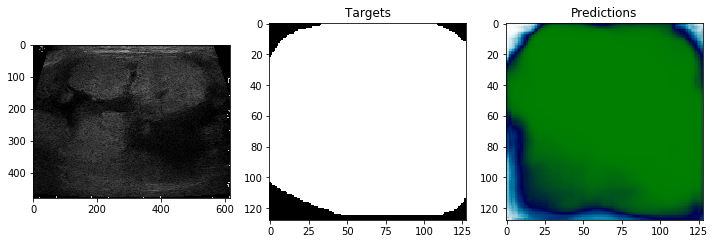

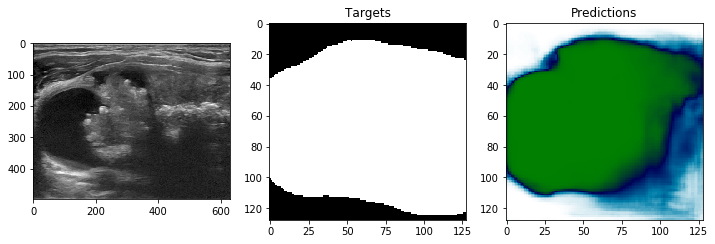

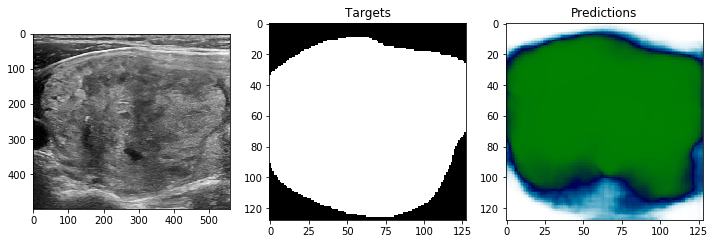

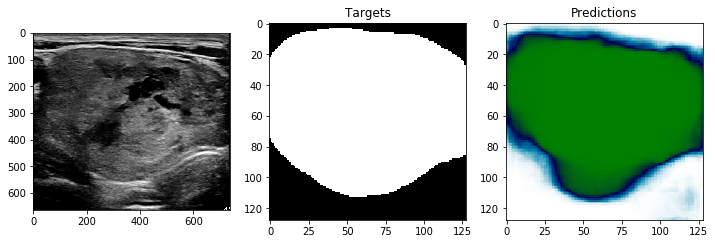

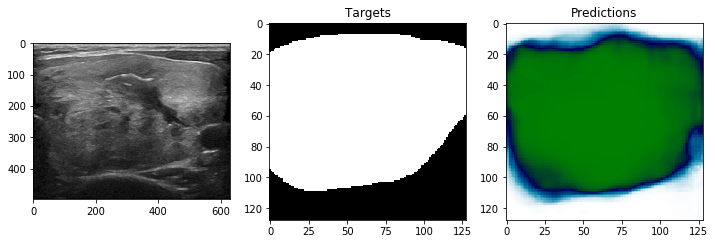

In [21]:
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(dls.valid_ds[idx][0])
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx][0], vmin=0, vmax=1, cmap=plt.cm.ocean)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

In [57]:
idx=0
x,y = dls.valid_ds[idx]

In [58]:
b = dls.one_batch()
xb_im = TensorImage(dls.train.decode(b)[0][0])
xb = b[0]

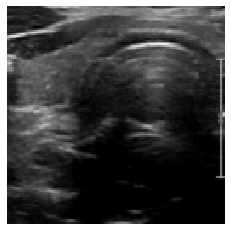

In [59]:

show_image(xb_im)

In [60]:
layers = flatten_model(learn.model)

In [61]:
custom_hook = hook_outputs(layers)

In [62]:
custom_hook.stored #inital are all empty

(#107) [None,None,None,None,None,None,None,None,None,None...]

In [63]:
learn.load('TNSC_two')

In [64]:
pre = learn.predict(img)
pre[0]

TensorMask([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [65]:
custom_hook.stored #now has values for each layer

(#107) [tensor([[[[ 7.3538e-01,  1.0339e+00,  4.7776e-01,  ...,  5.7685e+00,
            6.9201e+00,  5.4781e+00],
          [ 1.2122e-01, -6.7743e-01, -4.3888e-01,  ...,  9.2366e-01,
            7.8021e-01,  7.7526e-02],
          [-1.1634e-01, -2.4152e-02,  4.0635e-02,  ..., -1.3949e+00,
           -7.0377e-01,  6.3658e-01],
          ...,
          [-3.6913e-01, -8.2935e-01, -5.8668e-01,  ..., -3.9189e-01,
           -3.9189e-01, -3.3663e-01],
          [ 1.2178e-01,  1.9613e-01,  3.7801e-01,  ..., -3.9189e-01,
           -3.9189e-01, -3.3663e-01],
          [ 2.9604e+00,  3.4787e+00,  3.9266e+00,  ...,  5.1408e+00,
            5.1408e+00,  2.5937e+00]],

         [[ 2.1485e-01,  2.4232e-01,  4.4972e-02,  ...,  7.7358e+00,
            7.5226e+00,  6.7602e+00],
          [ 3.3440e-01,  2.7228e-01, -1.9321e-01,  ...,  2.0468e-01,
           -1.6072e+00, -3.3117e-01],
          [ 7.2303e-01,  1.4180e+00,  2.0996e+00,  ...,  2.7715e+00,
            2.5531e+00,  1.5530e+00],
          ..

In [66]:
m = learn.model.eval();
m

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [81]:

m[4]

UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (0): ConvLayer(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
      (1): Mish()
    )
    (1): PixelShuffle(upscale_factor=2)
  )
  (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): ConvLayer(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (conv2): ConvLayer(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Mish()
  )
  (relu): Mish()
)

In [87]:
hook_output(m[4]):
    preds = m(xb)
    print(preds)

SyntaxError: invalid syntax (<ipython-input-87-c088a68367ab>, line 1)

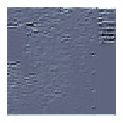

In [68]:
r = custom_hook.stored[0][0][0] # get values for first conv2d layer
e = TensorImage(r) #convert to TensorImage
show_image(e)

In [82]:
def hooked_backward(cat=y):
    with hook_output(m[4]) as hook_a: 
        with hook_output(m[4], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [83]:
hooked_backward()

TypeError: 'Hook' object is not callable

In [73]:
def v():
    i = 16
    layer = (f'conv2b_{i}')
    r = custom_hook.stored[i][0][0] # get values for first conv2d layer
    e = TensorImage(r)
    
    def hooked_backward(cat=y):
        with hook_output(m[5][0]) as hook_a: 
            with hook_output(m[5][0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    
    hook_a,hook_g = hooked_backward()
    activations  = hook_a.stored[0].cpu()
    gradients = hook_g.stored[0][0].cpu()
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    acts  = hook_a.stored[0].cpu()
    mult = (acts*grad_chan[...,None,None]).mean(0)
    
    _,axs = subplots(1, 2, figsize=(10,10))
    print(layer)
    TensorImage(r).show(ctx=axs[0], title='feature_map')
    TensorImage(mult).show(ctx=axs[1], alpha=0.9, interpolation='bilinear', cmap='inferno', title='heat_map')

In [75]:
UnetBlock??

In [74]:
v()

TypeError: 'UnetBlock' object is not subscriptable